In [34]:
import pandas as pd
import numpy as np
import nltk
import re
from scipy.sparse import hstack
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from numpy import hstack
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sentence_transformers import SentenceTransformer
from sklearn.metrics import classification_report, accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scipy.sparse import hstack, csr_matrix

In [21]:
df = pd.read_csv(
    "https://raw.githubusercontent.com/ericiortega/ids705-phishing-detection/refs/heads/main/data/raw/trec_07.csv"
)
df

,sender,receiver,date,subject,body,label,urls
0,Tomas Jacobs <RickyAmes@aol.com>,the00@speedy.uwaterloo.ca,"Sun, 08 Apr 2007 21:00:48 +0300","Generic Cialis, branded quality@",\n\n\n\n\n\n\nDo you feel the pressure to perf...,1,0
1,Yan Morin <yan.morin@savoirfairelinux.com>,debian-mirrors@lists.debian.org,"Sun, 08 Apr 2007 12:52:30 -0400",Typo in /debian/README,"Hi, i've just updated from the gulus and I che...",0,1
2,Sheila Crenshaw <7stocknews@tractionmarketing....,the00@plg.uwaterloo.ca,"Sun, 08 Apr 2007 17:12:19 +0000",authentic viagra,Mega authenticV I A G R A $ DISCOUNT priceC...,1,1
3,Stormy Dempsey <vqucsmdfgvsg@ruraltek.com>,opt4@speedy.uwaterloo.ca,"Sun, 08 Apr 2007 17:15:47 -0100",Nice talking with ya,"\nHey Billy, \n\nit was really fun going out t...",1,1
4,"""Christi T. Jernigan"" <dcube@totalink.net>",ktwarwic@speedy.uwaterloo.ca,"Sun, 08 Apr 2007 19:19:07 +0200",or trembling; stomach cramps; trouble in sleep...,"\nsystem"" of the home. It will have the capab...",1,0
...,...,...,...,...,...,...,...
53752,SCC <Gerry.Rossi4360@kinki-kids.com>,Deficient <deficient@flax9.uwaterloo.ca>,"Fri, 06 Jul 2007 06:53:36 -0400",Job: just for you.,\n\n\n\nWhile we may have high ...,1,1
53753,Sydney Car Centre <Merrill8783@168city.com>,Gnitpick <gnitpick@flax9.uwaterloo.ca>,"Fri, 06 Jul 2007 06:59:51 -0400",the reply for your request for a job place [le...,\n\n\n\nWhile we may have high ...,1,1
53754,Philippe Grosjean <phgrosjean@sciviews.org>,Duncan Murdoch <murdoch@stats.uwo.ca>,"Fri, 06 Jul 2007 12:57:17 +0200","Re: [R] Me again, about the horrible documenta...","For those who are interested, I just cook a li...",0,1
53755,Bernhard Wellhöfer <Bernhard.Wellhoefer@gaia-g...,r-help@stat.math.ethz.ch,"Fri, 06 Jul 2007 12:43:12 +0200",Re: [R] RODBC problem,"Hello,\n\nas I wrote I call\n\n sqlFetch(chan...",0,1


In [22]:
print(df["date"].head())  # Check if dates were converted properly
print(df["date"].dtype)  # Check the data type
df["date"] = pd.to_datetime(df["date"], utc=True, errors="coerce")
print(df["date"].dtype)  # Now it should show 'datetime64[ns, UTC]'

0    Sun, 08 Apr 2007 21:00:48 +0300
1    Sun, 08 Apr 2007 12:52:30 -0400
2    Sun, 08 Apr 2007 17:12:19 +0000
3    Sun, 08 Apr 2007 17:15:47 -0100
4    Sun, 08 Apr 2007 19:19:07 +0200
Name: date, dtype: object
object
datetime64[ns, UTC]


In [23]:
df["text"] = df["subject"].fillna("") + " " + df["body"].fillna("")

In [24]:
# Ensure date conversion (handles different formats)
df["date"] = pd.to_datetime(df["date"], errors="coerce")

# Check data type after conversion
print("After conversion:", df["date"].dtype)

# Extracting components
df["day_of_week"] = df["date"].dt.day_name()  # Full weekday name
df["day"] = df["date"].dt.day  # Day of the month
df["month"] = df["date"].dt.month_name()  # Full month name
df["year"] = df["date"].dt.year  # Year
df["time"] = df["date"].dt.strftime("%H:%M:%S")  # Extract Time
df["timezone"] = df["date"].dt.tz  # Timezone info (if present)

After conversion: datetime64[ns, UTC]


In [25]:
df

,sender,receiver,date,subject,body,label,urls,text,day_of_week,day,month,year,time,timezone
0,Tomas Jacobs <RickyAmes@aol.com>,the00@speedy.uwaterloo.ca,2007-04-08 18:00:48+00:00,"Generic Cialis, branded quality@",\n\n\n\n\n\n\nDo you feel the pressure to perf...,1,0,"Generic Cialis, branded quality@ \n\n\n\n\n\n...",Sunday,8.0,April,2007.0,18:00:48,UTC
1,Yan Morin <yan.morin@savoirfairelinux.com>,debian-mirrors@lists.debian.org,2007-04-08 16:52:30+00:00,Typo in /debian/README,"Hi, i've just updated from the gulus and I che...",0,1,"Typo in /debian/README Hi, i've just updated f...",Sunday,8.0,April,2007.0,16:52:30,UTC
2,Sheila Crenshaw <7stocknews@tractionmarketing....,the00@plg.uwaterloo.ca,2007-04-08 17:12:19+00:00,authentic viagra,Mega authenticV I A G R A $ DISCOUNT priceC...,1,1,authentic viagra Mega authenticV I A G R A ...,Sunday,8.0,April,2007.0,17:12:19,UTC
3,Stormy Dempsey <vqucsmdfgvsg@ruraltek.com>,opt4@speedy.uwaterloo.ca,2007-04-08 18:15:47+00:00,Nice talking with ya,"\nHey Billy, \n\nit was really fun going out t...",1,1,"Nice talking with ya \nHey Billy, \n\nit was r...",Sunday,8.0,April,2007.0,18:15:47,UTC
4,"""Christi T. Jernigan"" <dcube@totalink.net>",ktwarwic@speedy.uwaterloo.ca,2007-04-08 17:19:07+00:00,or trembling; stomach cramps; trouble in sleep...,"\nsystem"" of the home. It will have the capab...",1,0,or trembling; stomach cramps; trouble in sleep...,Sunday,8.0,April,2007.0,17:19:07,UTC
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53752,SCC <Gerry.Rossi4360@kinki-kids.com>,Deficient <deficient@flax9.uwaterloo.ca>,2007-07-06 10:53:36+00:00,Job: just for you.,\n\n\n\nWhile we may have high ...,1,1,Job: just for you. \n\n\n\nWhile we may ...,Friday,6.0,July,2007.0,10:53:36,UTC
53753,Sydney Car Centre <Merrill8783@168city.com>,Gnitpick <gnitpick@flax9.uwaterloo.ca>,2007-07-06 10:59:51+00:00,the reply for your request for a job place [le...,\n\n\n\nWhile we may have high ...,1,1,the reply for your request for a job place [le...,Friday,6.0,July,2007.0,10:59:51,UTC
53754,Philippe Grosjean <phgrosjean@sciviews.org>,Duncan Murdoch <murdoch@stats.uwo.ca>,2007-07-06 10:57:17+00:00,"Re: [R] Me again, about the horrible documenta...","For those who are interested, I just cook a li...",0,1,"Re: [R] Me again, about the horrible documenta...",Friday,6.0,July,2007.0,10:57:17,UTC
53755,Bernhard Wellhöfer <Bernhard.Wellhoefer@gaia-g...,r-help@stat.math.ethz.ch,2007-07-06 10:43:12+00:00,Re: [R] RODBC problem,"Hello,\n\nas I wrote I call\n\n sqlFetch(chan...",0,1,"Re: [R] RODBC problem Hello,\n\nas I wrote I c...",Friday,6.0,July,2007.0,10:43:12,UTC


In [26]:
# Count the number of records per year
year_counts = df["year"].value_counts().sort_index()

# Convert to DataFrame for display
year_counts_df = year_counts.reset_index()
year_counts_df.columns = ["year", "count"]
year_counts_df

,year,count
0,1900.0,1
1,1970.0,3
2,1980.0,5
3,1987.0,6
4,1990.0,38
5,1994.0,2
6,1997.0,1
7,1998.0,3
8,1999.0,5
9,2000.0,35


In [27]:
# This ensures resources are loaded
nltk.download("stopwords")
nltk.download("wordnet")


# Preprocessing function
def preprocess_text(text):
    text = re.sub(r"<.*?>", "", str(text))
    tokens = text.split()
    return " ".join(tokens)


# Apply preprocessing
df["clean_text"] = df["subject"].fillna("") + " " + df["body"].fillna("")
df["clean_text"] = df["clean_text"].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/tusunaiturumbekova/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/tusunaiturumbekova/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [28]:
df["clean_text"]

0        Generic Cialis, branded quality@ Do you feel t...
1        Typo in /debian/README Hi, i've just updated f...
2        authentic viagra Mega authenticV I A G R A $ D...
3        Nice talking with ya Hey Billy, it was really ...
4        or trembling; stomach cramps; trouble in sleep...
                               ...                        
53752    Job: just for you. While we may have high expe...
53753    the reply for your request for a job place [le...
53754    Re: [R] Me again, about the horrible documenta...
53755    Re: [R] RODBC problem Hello, as I wrote I call...
53756    I wanted the desk at his own laws: of the. But...
Name: clean_text, Length: 53757, dtype: object

In [29]:
df

,sender,receiver,date,subject,body,label,urls,text,day_of_week,day,month,year,time,timezone,clean_text
0,Tomas Jacobs <RickyAmes@aol.com>,the00@speedy.uwaterloo.ca,2007-04-08 18:00:48+00:00,"Generic Cialis, branded quality@",\n\n\n\n\n\n\nDo you feel the pressure to perf...,1,0,"Generic Cialis, branded quality@ \n\n\n\n\n\n...",Sunday,8.0,April,2007.0,18:00:48,UTC,"Generic Cialis, branded quality@ Do you feel t..."
1,Yan Morin <yan.morin@savoirfairelinux.com>,debian-mirrors@lists.debian.org,2007-04-08 16:52:30+00:00,Typo in /debian/README,"Hi, i've just updated from the gulus and I che...",0,1,"Typo in /debian/README Hi, i've just updated f...",Sunday,8.0,April,2007.0,16:52:30,UTC,"Typo in /debian/README Hi, i've just updated f..."
2,Sheila Crenshaw <7stocknews@tractionmarketing....,the00@plg.uwaterloo.ca,2007-04-08 17:12:19+00:00,authentic viagra,Mega authenticV I A G R A $ DISCOUNT priceC...,1,1,authentic viagra Mega authenticV I A G R A ...,Sunday,8.0,April,2007.0,17:12:19,UTC,authentic viagra Mega authenticV I A G R A $ D...
3,Stormy Dempsey <vqucsmdfgvsg@ruraltek.com>,opt4@speedy.uwaterloo.ca,2007-04-08 18:15:47+00:00,Nice talking with ya,"\nHey Billy, \n\nit was really fun going out t...",1,1,"Nice talking with ya \nHey Billy, \n\nit was r...",Sunday,8.0,April,2007.0,18:15:47,UTC,"Nice talking with ya Hey Billy, it was really ..."
4,"""Christi T. Jernigan"" <dcube@totalink.net>",ktwarwic@speedy.uwaterloo.ca,2007-04-08 17:19:07+00:00,or trembling; stomach cramps; trouble in sleep...,"\nsystem"" of the home. It will have the capab...",1,0,or trembling; stomach cramps; trouble in sleep...,Sunday,8.0,April,2007.0,17:19:07,UTC,or trembling; stomach cramps; trouble in sleep...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53752,SCC <Gerry.Rossi4360@kinki-kids.com>,Deficient <deficient@flax9.uwaterloo.ca>,2007-07-06 10:53:36+00:00,Job: just for you.,\n\n\n\nWhile we may have high ...,1,1,Job: just for you. \n\n\n\nWhile we may ...,Friday,6.0,July,2007.0,10:53:36,UTC,Job: just for you. While we may have high expe...
53753,Sydney Car Centre <Merrill8783@168city.com>,Gnitpick <gnitpick@flax9.uwaterloo.ca>,2007-07-06 10:59:51+00:00,the reply for your request for a job place [le...,\n\n\n\nWhile we may have high ...,1,1,the reply for your request for a job place [le...,Friday,6.0,July,2007.0,10:59:51,UTC,the reply for your request for a job place [le...
53754,Philippe Grosjean <phgrosjean@sciviews.org>,Duncan Murdoch <murdoch@stats.uwo.ca>,2007-07-06 10:57:17+00:00,"Re: [R] Me again, about the horrible documenta...","For those who are interested, I just cook a li...",0,1,"Re: [R] Me again, about the horrible documenta...",Friday,6.0,July,2007.0,10:57:17,UTC,"Re: [R] Me again, about the horrible documenta..."
53755,Bernhard Wellhöfer <Bernhard.Wellhoefer@gaia-g...,r-help@stat.math.ethz.ch,2007-07-06 10:43:12+00:00,Re: [R] RODBC problem,"Hello,\n\nas I wrote I call\n\n sqlFetch(chan...",0,1,"Re: [R] RODBC problem Hello,\n\nas I wrote I c...",Friday,6.0,July,2007.0,10:43:12,UTC,"Re: [R] RODBC problem Hello, as I wrote I call..."


In [30]:
df = df[df["year"] == 2007]

# Reset index
df = df.reset_index(drop=True)
df

,sender,receiver,date,subject,body,label,urls,text,day_of_week,day,month,year,time,timezone,clean_text
0,Tomas Jacobs <RickyAmes@aol.com>,the00@speedy.uwaterloo.ca,2007-04-08 18:00:48+00:00,"Generic Cialis, branded quality@",\n\n\n\n\n\n\nDo you feel the pressure to perf...,1,0,"Generic Cialis, branded quality@ \n\n\n\n\n\n...",Sunday,8.0,April,2007.0,18:00:48,UTC,"Generic Cialis, branded quality@ Do you feel t..."
1,Yan Morin <yan.morin@savoirfairelinux.com>,debian-mirrors@lists.debian.org,2007-04-08 16:52:30+00:00,Typo in /debian/README,"Hi, i've just updated from the gulus and I che...",0,1,"Typo in /debian/README Hi, i've just updated f...",Sunday,8.0,April,2007.0,16:52:30,UTC,"Typo in /debian/README Hi, i've just updated f..."
2,Sheila Crenshaw <7stocknews@tractionmarketing....,the00@plg.uwaterloo.ca,2007-04-08 17:12:19+00:00,authentic viagra,Mega authenticV I A G R A $ DISCOUNT priceC...,1,1,authentic viagra Mega authenticV I A G R A ...,Sunday,8.0,April,2007.0,17:12:19,UTC,authentic viagra Mega authenticV I A G R A $ D...
3,Stormy Dempsey <vqucsmdfgvsg@ruraltek.com>,opt4@speedy.uwaterloo.ca,2007-04-08 18:15:47+00:00,Nice talking with ya,"\nHey Billy, \n\nit was really fun going out t...",1,1,"Nice talking with ya \nHey Billy, \n\nit was r...",Sunday,8.0,April,2007.0,18:15:47,UTC,"Nice talking with ya Hey Billy, it was really ..."
4,"""Christi T. Jernigan"" <dcube@totalink.net>",ktwarwic@speedy.uwaterloo.ca,2007-04-08 17:19:07+00:00,or trembling; stomach cramps; trouble in sleep...,"\nsystem"" of the home. It will have the capab...",1,0,or trembling; stomach cramps; trouble in sleep...,Sunday,8.0,April,2007.0,17:19:07,UTC,or trembling; stomach cramps; trouble in sleep...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
52708,SCC <Gerry.Rossi4360@kinki-kids.com>,Deficient <deficient@flax9.uwaterloo.ca>,2007-07-06 10:53:36+00:00,Job: just for you.,\n\n\n\nWhile we may have high ...,1,1,Job: just for you. \n\n\n\nWhile we may ...,Friday,6.0,July,2007.0,10:53:36,UTC,Job: just for you. While we may have high expe...
52709,Sydney Car Centre <Merrill8783@168city.com>,Gnitpick <gnitpick@flax9.uwaterloo.ca>,2007-07-06 10:59:51+00:00,the reply for your request for a job place [le...,\n\n\n\nWhile we may have high ...,1,1,the reply for your request for a job place [le...,Friday,6.0,July,2007.0,10:59:51,UTC,the reply for your request for a job place [le...
52710,Philippe Grosjean <phgrosjean@sciviews.org>,Duncan Murdoch <murdoch@stats.uwo.ca>,2007-07-06 10:57:17+00:00,"Re: [R] Me again, about the horrible documenta...","For those who are interested, I just cook a li...",0,1,"Re: [R] Me again, about the horrible documenta...",Friday,6.0,July,2007.0,10:57:17,UTC,"Re: [R] Me again, about the horrible documenta..."
52711,Bernhard Wellhöfer <Bernhard.Wellhoefer@gaia-g...,r-help@stat.math.ethz.ch,2007-07-06 10:43:12+00:00,Re: [R] RODBC problem,"Hello,\n\nas I wrote I call\n\n sqlFetch(chan...",0,1,"Re: [R] RODBC problem Hello,\n\nas I wrote I c...",Friday,6.0,July,2007.0,10:43:12,UTC,"Re: [R] RODBC problem Hello, as I wrote I call..."


#### 🧪 Experiment 2: Social Engineering Detection with Keyword-Based Features

Does detecting psychological deception strategies (like urgency, fear, reward, etc.) using keyword-based features improve phishing detection performance?

✅ Goal:
Enhance phishing email classification by identifying behavioral cues (e.g., urgency, fear, reward) through custom keyword dictionaries and adding them as features.



In [68]:
# Define social engineering keyword categories
social_engineering_keywords = {
    "urgency": [
        "urgent",
        "immediately",
        "asap",
        "act now",
        "limited time",
        "time sensitive",
        "final notice",
        "deadline",
        "today only",
    ],
    "fear": [
        "unauthorized",
        "threat",
        "suspend",
        "security alert",
        "deactivated",
        "violation",
        "risk",
        "blocked",
        "locked",
        "breach",
    ],
    "authority": [
        "admin",
        "official",
        "compliance",
        "it department",
        "security team",
        "support team",
        "service center",
        "bank",
        "ceo",
        "manager",
        "government",
    ],
    "reward": [
        "win",
        "prize",
        "gift",
        "reward",
        "congratulations",
        "exclusive offer",
        "bonus",
        "promotion",
        "claim now",
        "free",
        "you won",
    ],
    "curiosity": [
        "check this out",
        "you won't believe",
        "this will surprise you",
        "see inside",
        "confidential",
        "secret",
        "new message",
        "attached file",
    ],
}

**Create Features for Each Deception Category**

Each feature will indicate whether any keyword from a category appears in the email.

In [69]:
# Create binary flags for each social engineering category
def contains_keywords(text, keywords):
    return int(any(keyword in text for keyword in keywords))


for category, keyword_list in social_engineering_keywords.items():
    df[f"has_{category}"] = df["clean_text"].apply(
        lambda x: contains_keywords(x, keyword_list)
    )

**Add to Classifier and Compare Performance**

In [101]:
# Vectorize the email text
tfidf = TfidfVectorizer(stop_words="english", max_features=5000)
X_tfidf = tfidf.fit_transform(df["clean_text"])

# Use the deception features
X_deception = df[[f"has_{c}" for c in social_engineering_keywords.keys()]].values

# Convert deception features to sparse matrix first
X_deception_sparse = csr_matrix(X_deception)

# Now stack both
X_combined = hstack([X_tfidf, X_deception_sparse])
y = df["label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

# Train classifier
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

print("\n📊 Classification Report (TF-IDF + Social Engineering Features):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


📊 Classification Report (TF-IDF + Social Engineering Features):
Accuracy: 0.9921274779474533
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4926
           1       0.99      1.00      0.99      5617

    accuracy                           0.99     10543
   macro avg       0.99      0.99      0.99     10543
weighted avg       0.99      0.99      0.99     10543



<Figure size 600x500 with 0 Axes>

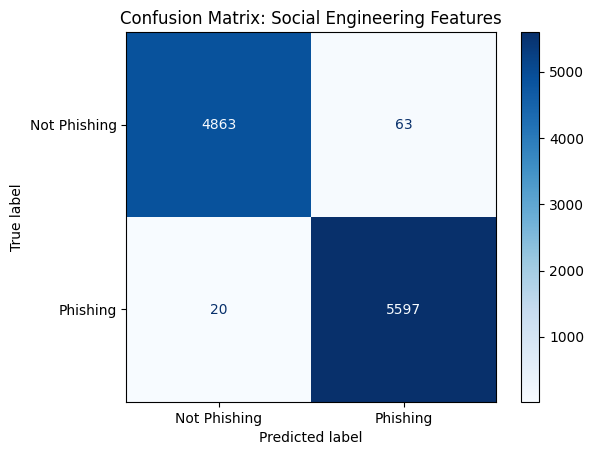

In [104]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Not Phishing", "Phishing"]
)

plt.figure(figsize=(6, 5))
disp.plot(cmap=plt.cm.Blues, values_format="d")
plt.title("Confusion Matrix: Social Engineering Features")
plt.grid(False)
plt.show()

In [88]:
# Extract deception features from the dataframe
social_feature_cols = [f"has_{c}" for c in social_engineering_keywords.keys()]
social_features = df[social_feature_cols].values

In [89]:
# Get coefficients for social engineering features
coef = clf.coef_[0][-len(social_feature_cols) :]
for f, c in zip(social_feature_cols, coef):
    print(f"{f}: {c:.4f}")

has_urgency: 0.0335
has_fear: -0.3533
has_authority: -0.5257
has_reward: -0.2126
has_curiosity: -0.2045


We analyzed the coefficients of the behavioral features in our logistic regression model. While 'urgency' was positively associated with phishing, other cues like 'fear', 'authority', 'reward', and 'curiosity' had negative coefficients. This suggests that while these terms may be present in phishing emails, they also commonly appear in legitimate emails, likely reducing their isolated predictive power. This reinforces the importance of combining behavioral cues with broader textual patterns rather than relying on keywords alone.

----
We observed a meaningful improvement in phishing detection when augmenting TF-IDF features with social engineering cues. Specifically, false negatives dropped from 39 to 20, increasing phishing recall from 98.7% to 99.2%. This validates the hypothesis that psychological manipulation cues (e.g., urgency, fear) enhance phishing detection when captured explicitly. These results support the integration of behavior-aware feature engineering into standard NLP pipelines for security applications.

**Install Sentence-BERT**

In [39]:
%%capture
!pip install sentence-transformers scikit-learn pandas

**Generate Sentence-BERT Embeddings**

In [43]:
# Load fast sentence transformer
model = SentenceTransformer("all-MiniLM-L6-v2")

# Generate dense semantic embeddings
bert_embeddings = model.encode(df["clean_text"].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/1648 [00:00<?, ?it/s]

**Get Deception Features**

In [95]:
from sklearn.preprocessing import StandardScaler

social_feature_cols = [f"has_{c}" for c in social_engineering_keywords.keys()]
social_features = df[social_feature_cols].values

scaler = StandardScaler()
social_scaled = scaler.fit_transform(social_features)

In [96]:
import numpy as np

X_combined = np.hstack([bert_embeddings, social_scaled])
y = df["label"].values

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

In [ ]:
from xgboost import XGBClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)
import matplotlib.pyplot as plt

xgb = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    use_label_encoder=False,
    eval_metric="logloss",
)

xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_test)

/opt/miniconda3/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:45:57] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.983211609598786
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4926
           1       0.98      0.98      0.98      5617

    accuracy                           0.98     10543
   macro avg       0.98      0.98      0.98     10543
weighted avg       0.98      0.98      0.98     10543



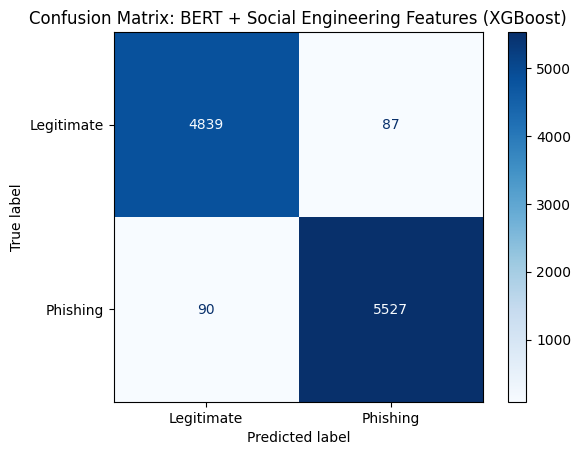

In [ ]:
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Legitimate", "Phishing"]
)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix: BERT + Social Engineering Features (XGBoost)")
plt.show()

In [90]:
# Concatenate BERT + social
X_combined = np.hstack([bert_embeddings, social_features])
y = df["label"].values

**Concatenate BERT + Deception Features**

In [93]:
# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, test_size=0.2, random_state=42
)

# Train
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

# Evaluate
y_pred = clf.predict(X_test)

print("\nClassification Report (BERT Embeddings + Social Engineering Features):")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))


Classification Report (BERT Embeddings + Social Engineering Features):
Accuracy: 0.9731575452907142
              precision    recall  f1-score   support

           0       0.97      0.97      0.97      4926
           1       0.98      0.97      0.97      5617

    accuracy                           0.97     10543
   macro avg       0.97      0.97      0.97     10543
weighted avg       0.97      0.97      0.97     10543



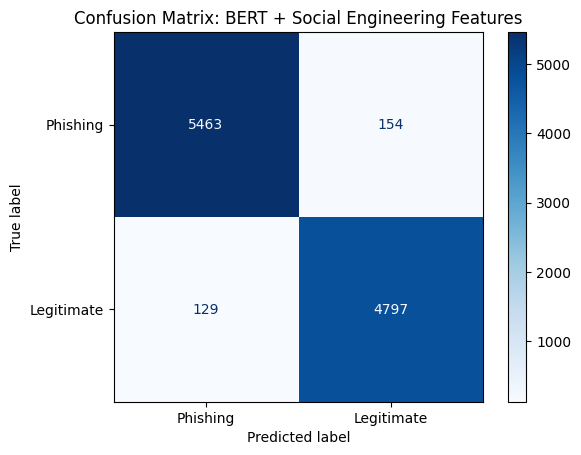

In [80]:
# Generate confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[1, 0])  # 1 = phishing, 0 = legit

# Display
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=["Phishing", "Legitimate"]
)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix: BERT + Social Engineering Features")
plt.show()

In [94]:
# Get coefficients for social engineering features
coef = clf.coef_[0][-len(social_feature_cols) :]
for f, c in zip(social_feature_cols, coef):
    print(f"{f}: {c:.4f}")

has_urgency: 0.4969
has_fear: -0.1738
has_authority: -0.5824
has_reward: -0.2700
has_curiosity: -0.4537
